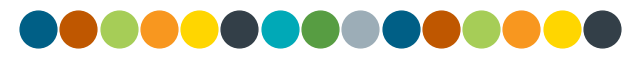

In [116]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# https://brand.utexas.edu/identity/color/
import random
from cycler import cycler

random.Random(12).shuffle(colors := '#bf5700 #f8971f #ffd600 #a6cd57 #579d42 #00a9b7 #005f86 #9cadb7 #333f48'.split(' '))
plt.figure(figsize=(8,0.5))
for i in range(15): plt.scatter(i,0,s=700)
plt.axis('off')
plt.show()
plt.rc('axes', prop_cycle=cycler(color=colors))


In [117]:

def plot_util(title:str, xlabel:str, ylabel:str, outer_legend:bool, xlim0:bool, ylim0:bool):
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if outer_legend: plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.25), ncol=2)
    else: plt.legend()
    plt.grid()
    if xlim0: plt.xlim(left=0)
    if ylim0: plt.ylim(bottom=0)

def my_save_fig(filename):
    IMAGE_DIRECTORY = r'./'
    plt.savefig(IMAGE_DIRECTORY+filename, bbox_inches='tight')

In [118]:
import os
metrics = []
for f in sorted(os.listdir('testmetrics')):
    with open('testmetrics/'+f, 'r') as f:
        line = f.read().split('Test')
        testacc = line[1].split(': ')[1]
        testtime = float(line[2].split(': ')[1].split("s")[0])*1000
        prunefrac = f.name.split('_')[2]
        metrics.append([prunefrac, testacc, testtime])
        
df = pd.DataFrame(metrics, columns=['prunefrac', 'testacc', 'testtime'])
df

,prunefrac,testacc,testtime
0,0.05,0.7467,404252.299547
1,0.1,0.7342,379954.131603
2,0.2,0.7072,298053.520679
3,0.3,0.6437,264924.595833
4,0.4,0.5322,185975.396633
5,0.5,0.3515,121496.378422


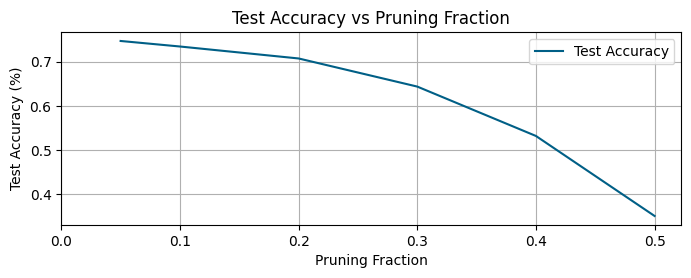

In [131]:
plt.figure(figsize=(8,2.5))

x = df['prunefrac'].astype(float).to_list()
y1 = df['testacc'].astype(float).to_list()


plt.plot(x, y1, label='Test Accuracy')
plot_util('Test Accuracy vs Pruning Fraction', 
          'Pruning Fraction', 'Test Accuracy (%)',
          False, True, False)
my_save_fig('testacc_vs_prunefrac.pdf')
plt.show()

In [128]:
#Get final parameter counts with each pruning fraction
with open('../m1_prune_att3/prune_m1.txt','r') as f:
    lines = f.read().split('Pruning Ratio:')
    pruning_results = lines[1:]
    pruning_results = [line.split('Before pruning:')[0] for line in pruning_results]
    fracs = [float(line.split('\n')[0].strip()) for line in pruning_results]
    params = [int(line.split('Total number of trainable parameters : ')[-1].strip()) for line in pruning_results]
    df['params'] = params
    
df

,prunefrac,testacc,testtime,params
0,0.05,0.7467,404252.299547,2902069
1,0.1,0.7342,379954.131603,2606173
2,0.2,0.7072,298053.520679,2066884
3,0.3,0.6437,264924.595833,1588917
4,0.4,0.5322,185975.396633,1174647
5,0.5,0.3515,121496.378422,823722


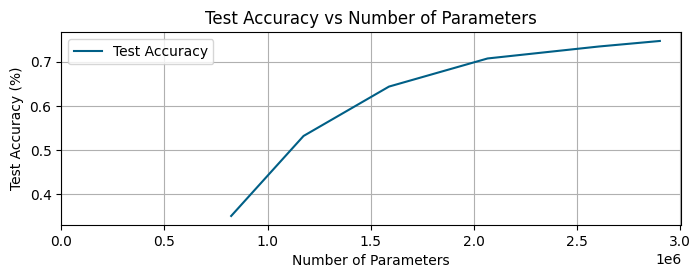

In [132]:
plt.figure(figsize=(8,2.5))

x = df['params'].astype(float).to_list()
y1 = df['testacc'].astype(float).to_list()


plt.plot(x, y1, label='Test Accuracy')
plot_util('Test Accuracy vs Number of Parameters', 
          'Number of Parameters', 'Test Accuracy (%)',
          False, True, False)
my_save_fig('testacc_vs_numparams.pdf')
plt.show()

In [106]:
# add columns necessary for m1.5
df['Fine-tuning epochs'] = 5 #epochs of fine-tuning
df['per-image latency'] = (df['testtime'].astype(float)/10000) #millisecond per image
df.rename(columns={'testacc':'Test accuracy', 'prunefrac':"Pruning Fraction", 'testtime':"Total Inference Time (ms)", 'params':"Number of Parameters", 'per-image latency': "Inference time per image (ms)"}, inplace=True)
df

,Pruning Fraction,Test accuracy,Total Inference Time (ms),Number of Parameters,Fine-tuning epochs,Inference time per image (ms)
0,0.05,0.7467,404252.299547,2902069,5,40.425230
1,0.1,0.7342,379954.131603,2606173,5,37.995413
2,0.2,0.7072,298053.520679,2066884,5,29.805352
3,0.3,0.6437,264924.595833,1588917,5,26.492460
4,0.4,0.5322,185975.396633,1174647,5,18.597540
5,0.5,0.3515,121496.378422,823722,5,12.149638


In [107]:
#Get max memory usage of each pruning fraction
#format of each line is:
#total        used        free      shared  buff/cache   available
for f in sorted(os.listdir('./test_RAM_onnxs/')):
    _pf = f.split('_')[2]
    maxused = 0
    with open('./test_RAM_onnxs/'+f, 'r') as f:
        memlines = [",".join(line.strip().split()[1:]) for line in f if line.startswith('Mem: ')]
        memlines = [line.split(',') for line in memlines]
        memdf = pd.DataFrame(memlines, columns=['total','used', 'free', 'shared', 'buff/cache', 'available'])
        maxused = memdf['used'].astype(int).max()
        print(maxused)
        # print(memdf)
    df.loc[df['Pruning Fraction'] == _pf, 'Max RAM usage (Mb)'] = maxused
    # break
df

138
135
132
130
128
127


,Pruning Fraction,Test accuracy,Total Inference Time (ms),Number of Parameters,Fine-tuning epochs,Inference time per image (ms),Max RAM usage (Mb)
0,0.05,0.7467,404252.299547,2902069,5,40.425230,138.0
1,0.1,0.7342,379954.131603,2606173,5,37.995413,135.0
2,0.2,0.7072,298053.520679,2066884,5,29.805352,132.0
3,0.3,0.6437,264924.595833,1588917,5,26.492460,130.0
4,0.4,0.5322,185975.396633,1174647,5,18.597540,128.0
5,0.5,0.3515,121496.378422,823722,5,12.149638,127.0


In [108]:
#get max power consumption and average energy in joules per image
for f in sorted(os.listdir('./power_temp/')):
    powertempdf = pd.read_csv('./power_temp/'+f)
    _pf = f.split('_')[2]
    df.loc[df['Pruning Fraction'] == _pf, 'Max power consumption (W)'] = powertempdf['Power'].max() # max power in watts
    print(powertempdf['Power'].mean())
    df.loc[df['Pruning Fraction'] == _pf, 'Average energy per image (J)'] = powertempdf['Power'].mean()*df.loc[df['Pruning Fraction'] == _pf, 'Inference time per image (ms)'].values[0]/1000 # average power in watts * time in seconds per image


df

6.173280319857841
6.177161998132586
6.2257282798833815
6.15411590470058
6.21196584938704
6.310616858237547


,Pruning Fraction,Test accuracy,Total Inference Time (ms),Number of Parameters,Fine-tuning epochs,Inference time per image (ms),Max RAM usage (Mb),Max power consumption (W),Average energy per image (J)
0,0.05,0.7467,404252.299547,2902069,5,40.425230,138.0,6.706,0.249556
1,0.1,0.7342,379954.131603,2606173,5,37.995413,135.0,6.512,0.234704
2,0.2,0.7072,298053.520679,2066884,5,29.805352,132.0,6.542,0.185560
3,0.3,0.6437,264924.595833,1588917,5,26.492460,130.0,6.588,0.163038
4,0.4,0.5322,185975.396633,1174647,5,18.597540,128.0,6.576,0.115527
5,0.5,0.3515,121496.378422,823722,5,12.149638,127.0,6.576,0.076672


In [109]:
pretty_df = df[['Pruning Fraction', 'Fine-tuning epochs', 'Number of Parameters', 'Max RAM usage (Mb)', 'Inference time per image (ms)','Max power consumption (W)', 'Average energy per image (J)']]
pretty_df

,Pruning Fraction,Fine-tuning epochs,Number of Parameters,Max RAM usage (Mb),Inference time per image (ms),Max power consumption (W),Average energy per image (J)
0,0.05,5,2902069,138.0,40.425230,6.706,0.249556
1,0.1,5,2606173,135.0,37.995413,6.512,0.234704
2,0.2,5,2066884,132.0,29.805352,6.542,0.185560
3,0.3,5,1588917,130.0,26.492460,6.588,0.163038
4,0.4,5,1174647,128.0,18.597540,6.576,0.115527
5,0.5,5,823722,127.0,12.149638,6.576,0.076672


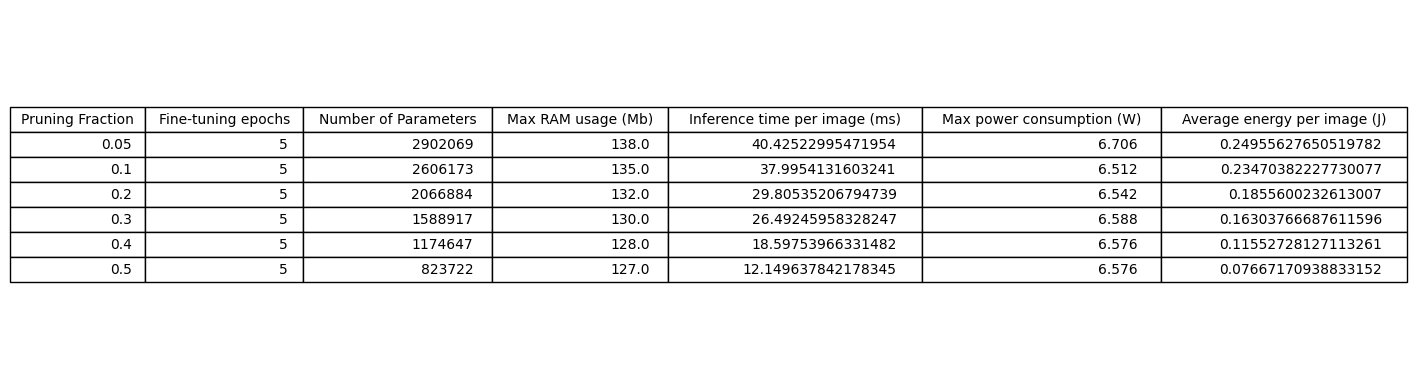

In [110]:
table = plt.table(cellText=pretty_df.values, colLabels=pretty_df.columns, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)
table.auto_set_column_width(col=list(range(len(pretty_df.columns))))
plt.axis('off')
plt.savefig('1.5.pdf', bbox_inches='tight')
